In [1]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
# from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

In [2]:
# pip install -U huggingface_hub

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = '/content/drive/MyDrive/bert/english/englishintents.json'

In [5]:
def load_json_file(data_path):
    with open(data_path, 'r') as f:
        file = json.load(f)

    return file

In [6]:
intents = load_json_file(data_path)

In [7]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })

    return df

df = create_df()
df

,Pattern,Tag


In [8]:
def extract_json_info(json_file, df):

    for intent in json_file['intents']:

        for pattern in intent['patterns']:

            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag

    return df

df = extract_json_info(intents, df)
df.head()


,Pattern,Tag
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Hi chatbot,greeting


In [9]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Hi chatbot,greeting


In [10]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(df, "Chatbot")

Chatbot dataset has 669 rows and 2 columns


In [11]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669 entries, 0 to 668
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  669 non-null    object
 1   Tag      669 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB
None


In [12]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 67 classes


In [13]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")


Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


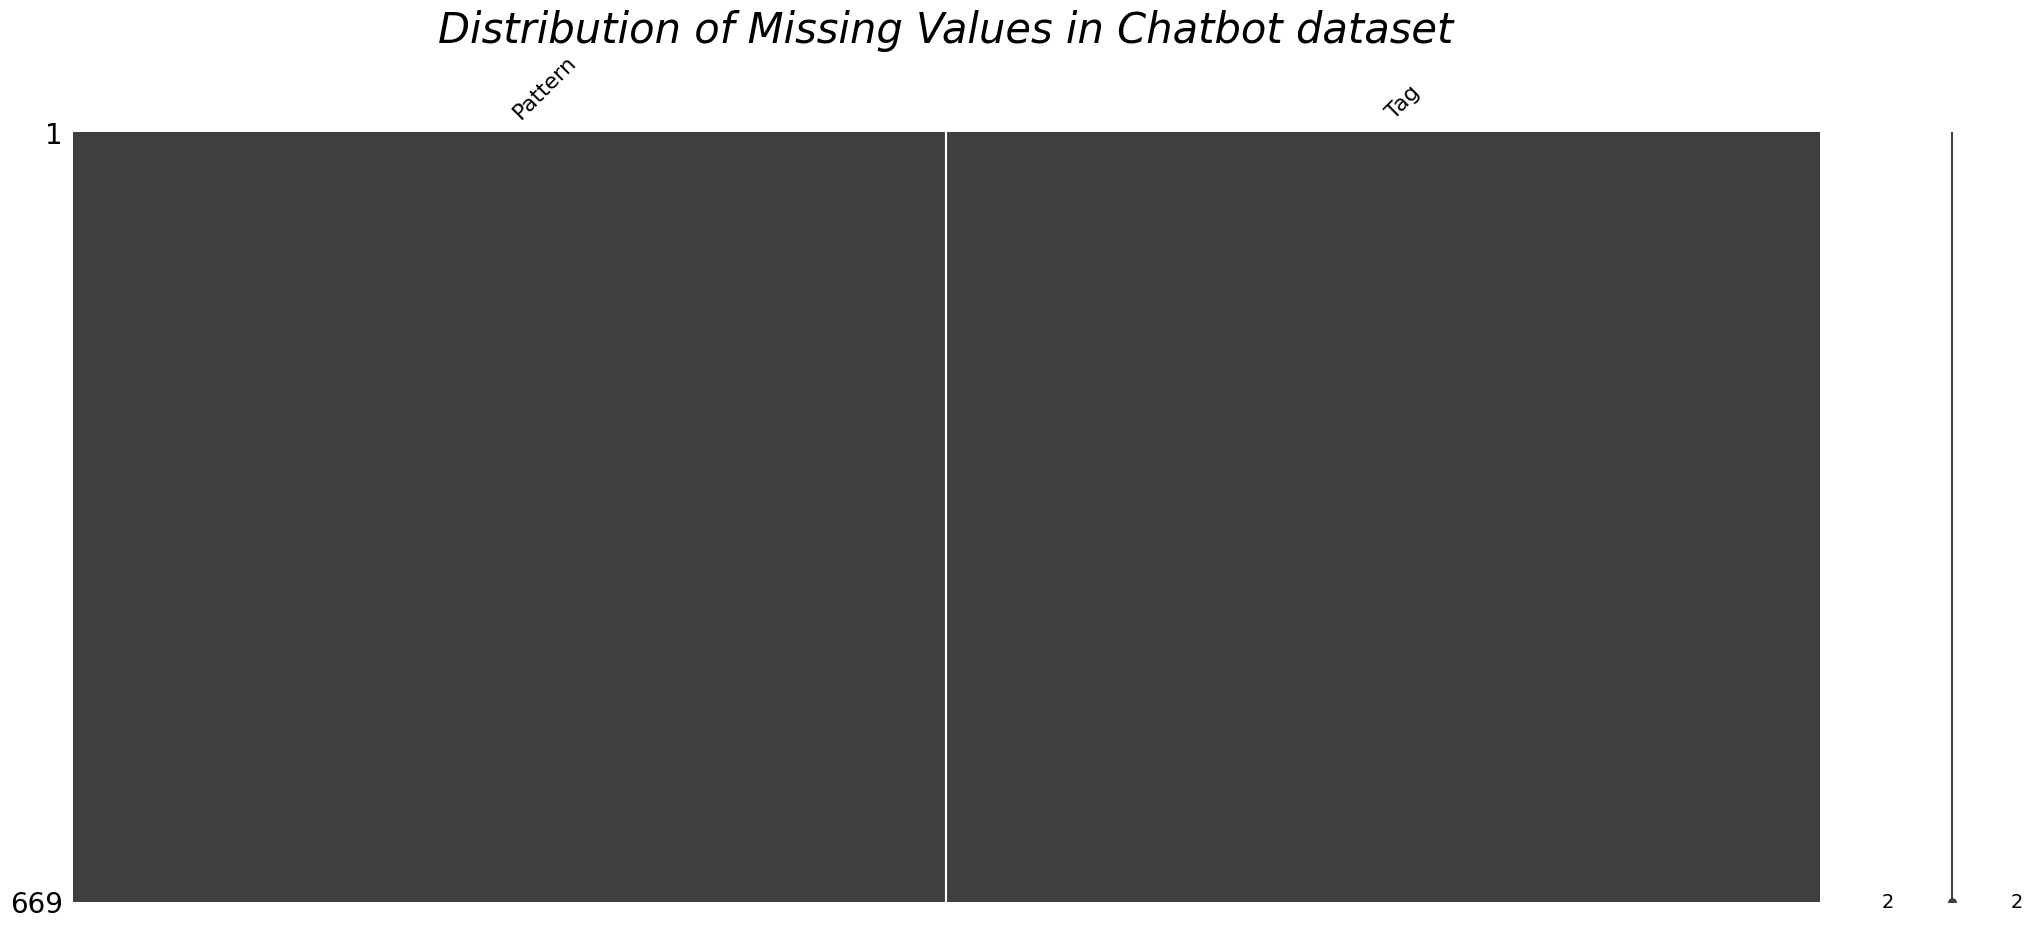

In [14]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

plot_miss_vals(df, "Chatbot")

In [15]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

Total number of patterns associated with each tag


<ipython-input-15-63e4ac2f4c5f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)


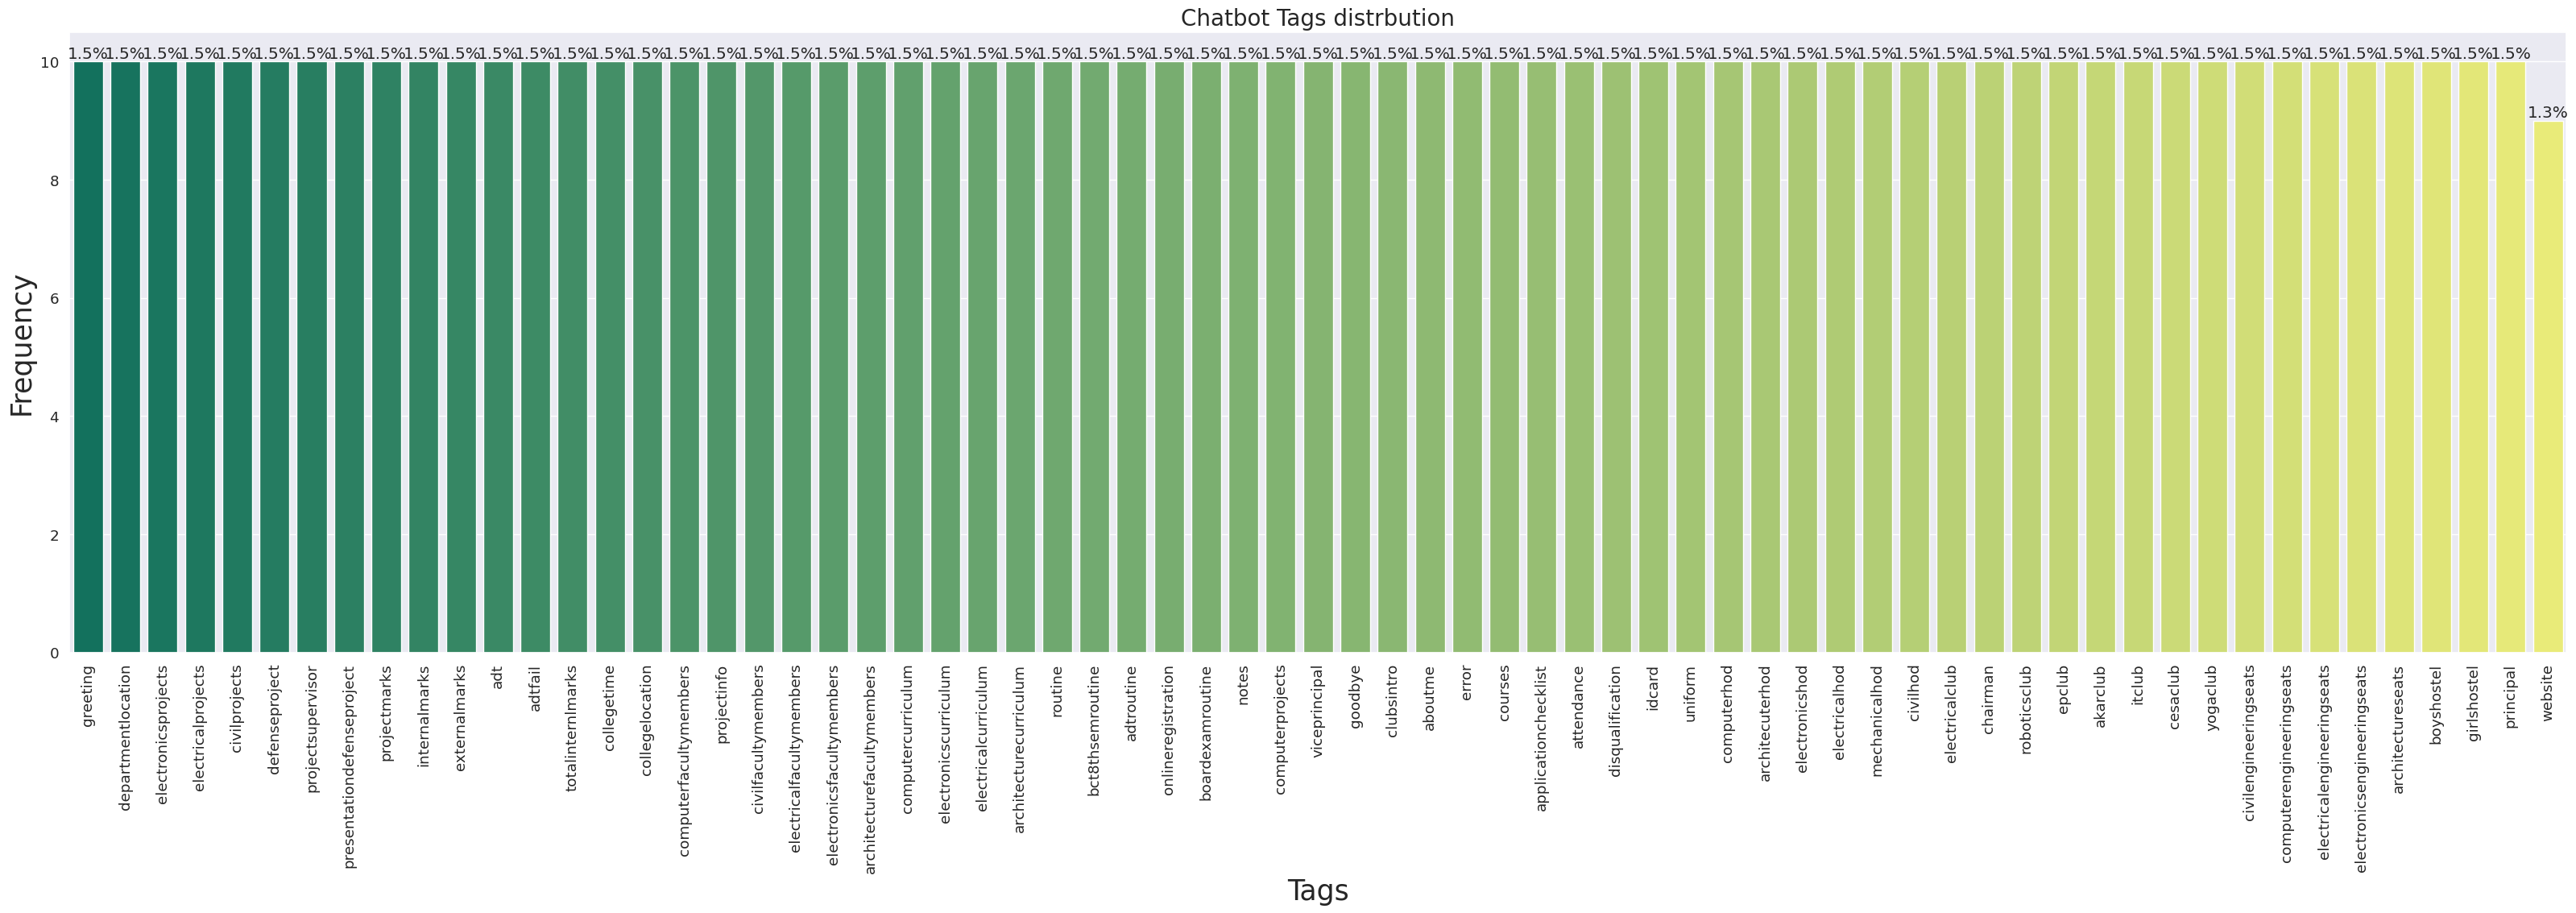

In [16]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 40,10, order=order,rotation=True, palette="summer")

In [17]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
import nltk

In [19]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

In [20]:
df.head()

,Pattern,Tag
0,hi,greeting
1,hey,greeting
2,is anyon there,greeting
3,hello,greeting
4,hi chatbot,greeting


In [21]:
print(df['Pattern'].isnull().sum())

0


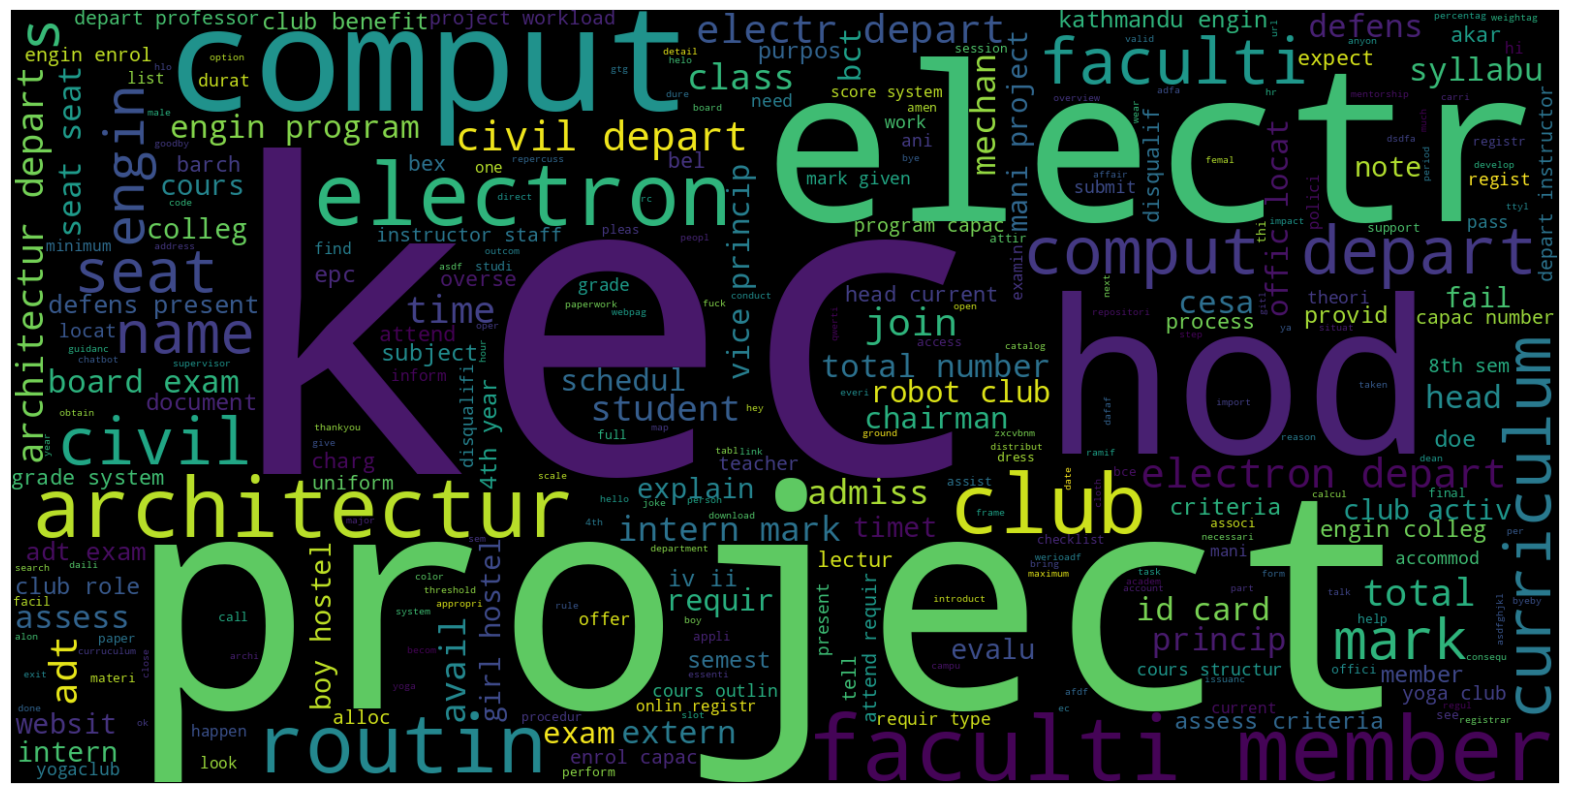

In [22]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

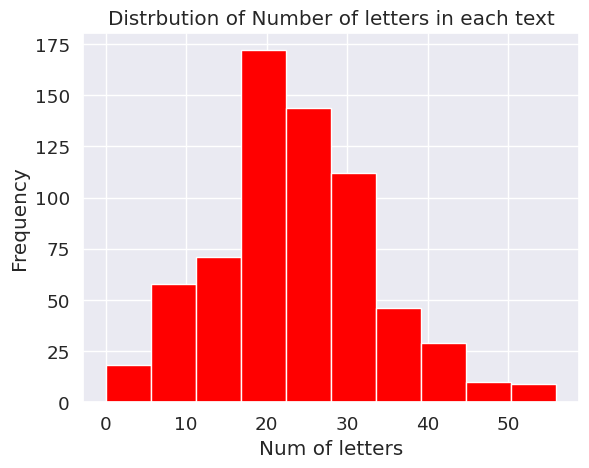

In [23]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

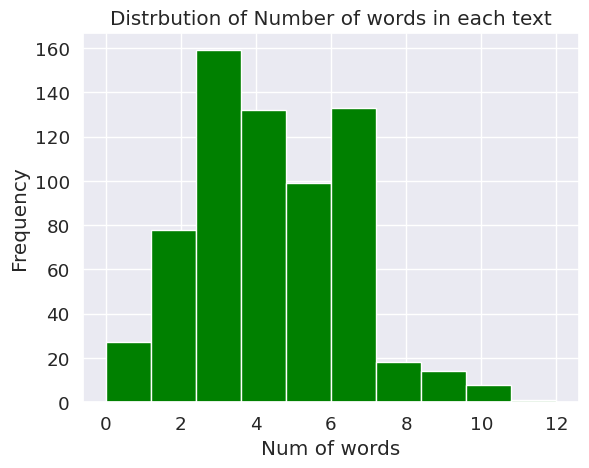

In [24]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-25-c5010b3a990f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,color='red')


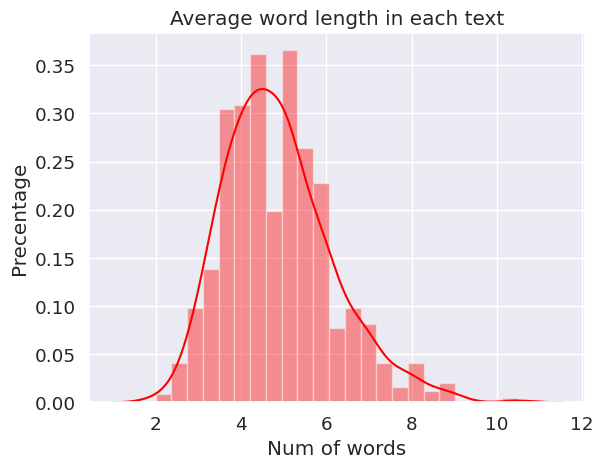

In [25]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

In [26]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['hi', 'hey', 'is', 'anyon', 'there']

In [27]:
print(f"dataset contains {len(corpus)} words")

dataset contains 2893 words


In [28]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'of': 146,
 'for': 107,
 'the': 106,
 'project': 101,
 'depart': 95,
 'kec': 93,
 'in': 86,
 'is': 62,
 'club': 62,
 'comput': 60}

In [29]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

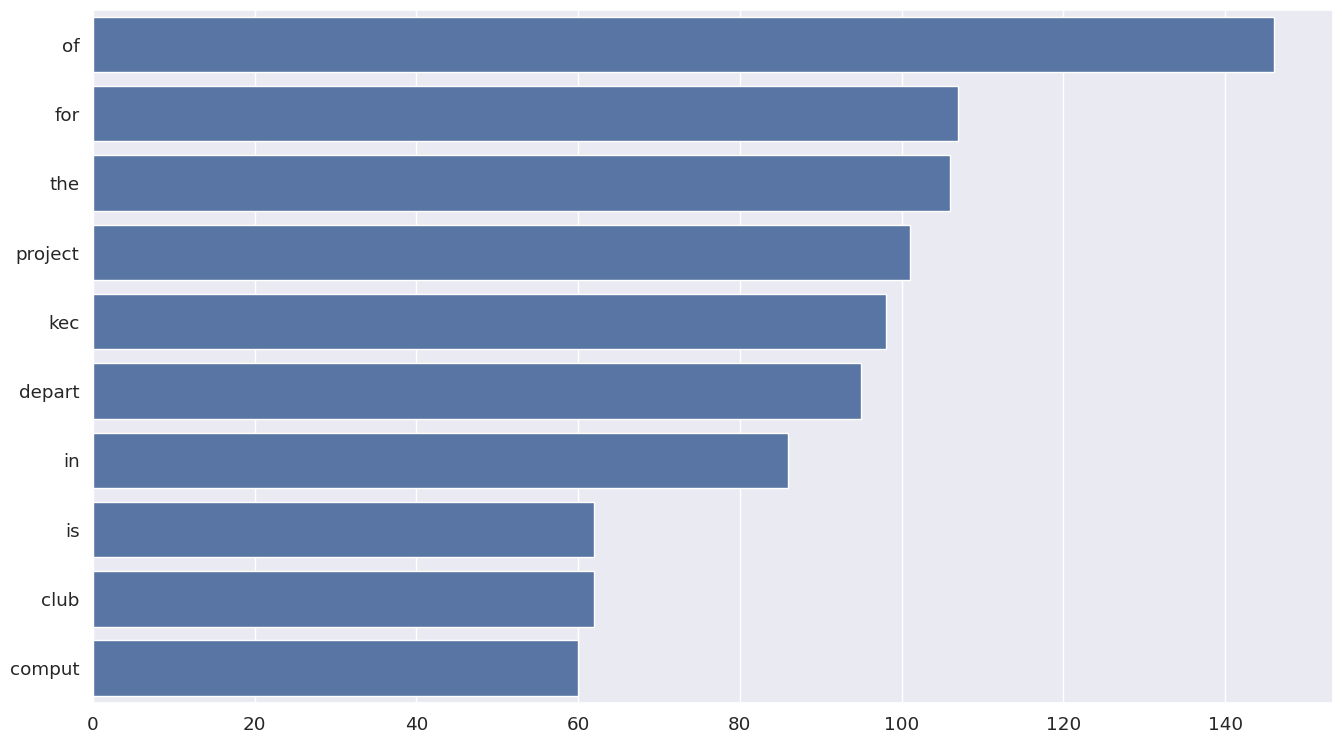

In [30]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

In [31]:
df2.head()

,Pattern,Tag
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Hi chatbot,greeting


In [32]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'aboutme',
 'error',
 'courses',
 'applicationchecklist',
 'attendance',
 'disqualification',
 'idcard',
 'uniform',
 'computerhod',
 'architecuterhod',
 'electronicshod',
 'electricalhod',
 'mechanicalhod',
 'civilhod',
 'clubsintro',
 'electricalclub',
 'roboticsclub',
 'epclub',
 'akarclub',
 'itclub',
 'cesaclub',
 'yogaclub',
 'civilengineeringseats',
 'computerengineeringseats',
 'electricalengineeringseats',
 'electronicsengineeringseats',
 'architectureseats',
 'boyshostel',
 'girlshostel',
 'principal',
 'chairman',
 'viceprincipal',
 'projectinfo',
 'computerprojects',
 'electronicsprojects',
 'electricalprojects',
 'civilprojects',
 'defenseproject',
 'projectsupervisor',
 'presentationdefenseproject',
 'projectmarks',
 'internalmarks',
 'externalmarks',
 'adt',
 'adtfail',
 'totalinternlmarks',
 'collegetime',
 'collegelocation',
 'departmentlocation',
 'computerfacultymembers',
 'civilfacultymembers',
 'electricalfacultymembers',
 'electronicsfacu

In [33]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [34]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'aboutme',
 3: 'error',
 4: 'courses',
 5: 'applicationchecklist',
 6: 'attendance',
 7: 'disqualification',
 8: 'idcard',
 9: 'uniform',
 10: 'computerhod',
 11: 'architecuterhod',
 12: 'electronicshod',
 13: 'electricalhod',
 14: 'mechanicalhod',
 15: 'civilhod',
 16: 'clubsintro',
 17: 'electricalclub',
 18: 'roboticsclub',
 19: 'epclub',
 20: 'akarclub',
 21: 'itclub',
 22: 'cesaclub',
 23: 'yogaclub',
 24: 'civilengineeringseats',
 25: 'computerengineeringseats',
 26: 'electricalengineeringseats',
 27: 'electronicsengineeringseats',
 28: 'architectureseats',
 29: 'boyshostel',
 30: 'girlshostel',
 31: 'principal',
 32: 'chairman',
 33: 'viceprincipal',
 34: 'projectinfo',
 35: 'computerprojects',
 36: 'electronicsprojects',
 37: 'electricalprojects',
 38: 'civilprojects',
 39: 'defenseproject',
 40: 'projectsupervisor',
 41: 'presentationdefenseproject',
 42: 'projectmarks',
 43: 'internalmarks',
 44: 'externalmarks',
 45: 'adt',
 46: 'adtfail',


In [35]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'aboutme': 2,
 'error': 3,
 'courses': 4,
 'applicationchecklist': 5,
 'attendance': 6,
 'disqualification': 7,
 'idcard': 8,
 'uniform': 9,
 'computerhod': 10,
 'architecuterhod': 11,
 'electronicshod': 12,
 'electricalhod': 13,
 'mechanicalhod': 14,
 'civilhod': 15,
 'clubsintro': 16,
 'electricalclub': 17,
 'roboticsclub': 18,
 'epclub': 19,
 'akarclub': 20,
 'itclub': 21,
 'cesaclub': 22,
 'yogaclub': 23,
 'civilengineeringseats': 24,
 'computerengineeringseats': 25,
 'electricalengineeringseats': 26,
 'electronicsengineeringseats': 27,
 'architectureseats': 28,
 'boyshostel': 29,
 'girlshostel': 30,
 'principal': 31,
 'chairman': 32,
 'viceprincipal': 33,
 'projectinfo': 34,
 'computerprojects': 35,
 'electronicsprojects': 36,
 'electricalprojects': 37,
 'civilprojects': 38,
 'defenseproject': 39,
 'projectsupervisor': 40,
 'presentationdefenseproject': 41,
 'projectmarks': 42,
 'internalmarks': 43,
 'externalmarks': 44,
 'adt': 45,
 'adtfail': 46,


In [36]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Hi,greeting,0
1,Hey,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Hi chatbot,greeting,0


In [37]:
X = list(df2['Pattern'])
X[:5]

['Hi', 'Hey', 'Is anyone there?', 'Hello', 'Hi chatbot']

In [38]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [39]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

In [40]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

501
168
501
168


In [41]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [43]:
full_data = tokenizer(X, truncation=True, padding=True)

In [44]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [45]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [46]:
fullDataLoader = DataLoader(full_data, y_test)

In [47]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [48]:
# pip install accelerate -U

In [49]:
# pip install transformers[torch]

In [50]:
pip install accelerate>=0.21.0 -U


In [51]:
from transformers import AdamW

In [52]:
# Define optimizer and loss function
# optimizer = AdamW(model.parameters(), lr=5e-5)  # AdamW optimizer
# loss_fn = torch.nn.CrossEntropyLoss()  # CrossEntropyLoss


Add early stopping

In [53]:
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=30,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True,
)

In [54]:
# !pip install pytorch-lightning

In [55]:
# from pytorch_lightning.callbacks import EarlyStoppingCallback

In [56]:
# early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

In [57]:
from transformers import EarlyStoppingCallback

In [58]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    # optimizers=(optimizer, None)
)

Training

In [59]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,4.189600,4.022067,0.035714,0.011377,0.018125,0.038557
100,3.748000,3.465183,0.232143,0.188167,0.226867,0.264925
150,2.813800,2.398129,0.625000,0.622532,0.648827,0.684080
200,1.725500,1.545813,0.815476,0.822862,0.843959,0.863433
250,0.987600,1.008930,0.886905,0.884577,0.893781,0.912687
300,0.582600,0.676687,0.904762,0.905473,0.908955,0.920647
350,0.348800,0.513894,0.928571,0.934222,0.942786,0.940547
400,0.240300,0.423945,0.928571,0.930715,0.936567,0.938557
450,0.189900,0.408639,0.922619,0.920185,0.921642,0.933085


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

TrainOutput(global_step=480, training_loss=1.5553020377953848, metrics={'train_runtime': 2844.0439, 'train_samples_per_second': 5.285, 'train_steps_per_second': 0.169, 'total_flos': 123652096171200.0, 'train_loss': 1.5553020377953848, 'epoch': 30.0})

In [110]:
from transformers import BertTokenizer, BertForSequenceClassification

In [106]:
train_metrics = trainer.evaluate(train_dataloader)
val_metrics = trainer.evaluate(test_dataloader)

print("Training Metrics:", train_metrics)
print("Validation Metrics:", val_metrics)


Training Metrics: {'eval_loss': 0.12619046866893768, 'eval_Accuracy': 0.998003992015968, 'eval_F1': 0.9981270119988294, 'eval_Precision': 0.9983416252072969, 'eval_Recall': 0.9981343283582089, 'eval_runtime': 30.6153, 'eval_samples_per_second': 16.364, 'eval_steps_per_second': 1.045, 'epoch': 30.0}
Validation Metrics: {'eval_loss': 0.3968157470226288, 'eval_Accuracy': 0.9404761904761905, 'eval_F1': 0.9441483060886046, 'eval_Precision': 0.9490049751243781, 'eval_Recall': 0.9485074626865672, 'eval_runtime': 10.8474, 'eval_samples_per_second': 15.488, 'eval_steps_per_second': 1.014, 'epoch': 30.0}


In [107]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.126190,0.998004,0.998127,0.998342,0.998134
test,0.396816,0.940476,0.944148,0.949005,0.948507


In [111]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cpu")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [112]:
text = "Hello"
predict(text)

(tensor([[0.2675, 0.7325]], grad_fn=<SoftmaxBackward0>), tensor(1), 'LABEL_1')

In [ ]:
!pip install xformers

In [113]:
model_path = "/content/drive/MyDrive/crazy/english/model"
tokenizer_path = "/content/drive/MyDrive/crazy/english/tokenizer"

In [114]:
trainer.save_model(model_path)
tokenizer.save_pretrained(tokenizer_path)


('/content/drive/MyDrive/crazy/english/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/crazy/english/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/crazy/english/tokenizer/vocab.txt',
 '/content/drive/MyDrive/crazy/english/tokenizer/added_tokens.json')

In [115]:
model_path = "/content/drive/MyDrive/crazy/english/model"
tokenizer_path = "/content/drive/MyDrive/crazy/english/tokenizer"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(tokenizer_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [116]:
chatbot("Hello")

[{'label': 'greeting', 'score': 0.9217389822006226}]

In [82]:
print(label2id)


{'greeting': 0, 'goodbye': 1, 'aboutme': 2, 'error': 3, 'courses': 4, 'applicationchecklist': 5, 'attendance': 6, 'disqualification': 7, 'idcard': 8, 'uniform': 9, 'computerhod': 10, 'architecuterhod': 11, 'electronicshod': 12, 'electricalhod': 13, 'mechanicalhod': 14, 'civilhod': 15, 'clubsintro': 16, 'electricalclub': 17, 'roboticsclub': 18, 'epclub': 19, 'akarclub': 20, 'itclub': 21, 'cesaclub': 22, 'yogaclub': 23, 'civilengineeringseats': 24, 'computerengineeringseats': 25, 'electricalengineeringseats': 26, 'electronicsengineeringseats': 27, 'architectureseats': 28, 'boyshostel': 29, 'girlshostel': 30, 'principal': 31, 'chairman': 32, 'viceprincipal': 33, 'projectinfo': 34, 'computerprojects': 35, 'electronicsprojects': 36, 'electricalprojects': 37, 'civilprojects': 38, 'defenseproject': 39, 'projectsupervisor': 40, 'presentationdefenseproject': 41, 'projectmarks': 42, 'internalmarks': 43, 'externalmarks': 44, 'adt': 45, 'adtfail': 46, 'totalinternlmarks': 47, 'collegetime': 48, 'c

In [117]:
def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")

    text = input("User: ").strip().lower()

    while(text != 'quit'):

        score = chatbot(text)[0]['score']

        if score < 0.5:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue

        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])

        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()

In [119]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat


User: hi
Chatbot: Hi,I am KEC Chatbot.If you have any questions,feel free to ask.


User: where is kec located?
Chatbot: Our college is located at kalimati,kathmandu.For detailed direction <a target="_blank" href="https://maps.app.goo.gl/CPpCvJfDe2wkCBr3A">visit here</a>


User: who are computer faculty members
Chatbot: {'text': 'Computer Faculty Members:', 'table': {'headers': ['Name', 'Position'], 'rows': [['Er. Sudeep Shakya', 'HOD / Associate Professor'], ['Er. Kunjan Amatya', 'Dy. HOD / Associate professor/ Research Member'], ['Er. Mahesh Singh Kathayat', 'Academic Advisor / Associate Professor'], ['Er. Shyam Dahal', 'Hostel Warden / Associate Professor'], ['Er. Shree Krishna Sulu', 'Dy. Exam Head / Associate Professor'], ['Er. Nabin Neupane', '3rd Year Coordinator / Associate Professor'], ['Er. Sharad Chandra Joshi', 'Associat